# Inverse Ising problem

This notebook gives examples of how to use the various solvers included in CONIII for solving the inverse Ising problem. In this problem, the goal is to match the average orientation of each spin (the magnetization) $\{\langle\sigma_{\rm i}\rangle\}$ and the pairwise correlations $\{\langle\sigma_{\rm i}\sigma_{\rm j}\rangle\}$ by finding the fields $\{h_{\rm i}\}$ and couplings $\{J_{\rm ij}\}$. This problem is explained in further detail in the accompanying paper.
<br><br><br>
The Ising model is given by  
$p(\{\sigma_{\rm i}\}) = \left.e^{-E(\{\sigma_{\rm i}\})}\right/Z$  
$\displaystyle E(\{\sigma_{\rm i}\}) = -\sum_{\rm ij}J_{\rm ij}\sigma_{\rm i}\sigma_{\rm j} -\sum_{\rm i}^Nh_{\rm i}$  
$Z = \displaystyle \sum_{\{\sigma_{\rm i}\}} e^{-E(\{\sigma_{\rm i}\})}$
<br><br>
## Quick guide
Each algorithm for solving the inverse Ising problem is a class. To use an algorithm, an instance of the class must be declared and the `solve()` method called. For some of the methods, you will also need to declare some helper functions that the algorithm needs. For the general case of the pairwise maxent model, these helper functions are already part of the package, and you should be able to import them.<br><br>
Most of the classes require the user to specify the maxent problem by defining `calc_observables()`. Here, "observables" refers to the constraints that are imposed in the model and these must be calculated from some sample of states. The term "multipliers" refers to Langrangian multipliers (or parameters) that are found such that the constraints are met.<br><br>
This notebook is structured such that it starts with setting up a simple $n=5$ model to solve. In this case, there are 15 parameters to find. Five parameters are the mean fields $h_{\rm i}$ corresponding to the magnetization of the spins and ten parameters are for the pairwise correlations.<br><br>
The following sections are examples using each of the algorithms.
<br><br>
## Troubleshooting
Some users may encounter difficulties with the multiprocess module in which case the n_jobs kwarg should be set to 0 when the Solver instance is declared.

In [1]:
# Setup iPython environment.
%pylab inline
plt.rc('font',size=20)

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup
This section sets up an $n=5$ Ising problem to test. The model is generated by sampling random fields and couplings and sampling from the resulting distribution. The inverse problem will be solved with the various algorithms in the following sections.

In [2]:
# Import common libraries.
from __future__ import division
from coniii import *

# Add path to files for solving the n=5 system exactly. This is included as an example for the package, but you can create your own by using the exact module.
# To create ising_eqn_5_sym.py, run in the shell
# >>> python exact.py 5 1
from coniii.ising_eqn import ising_eqn_5_sym

# Define common functions.
calc_e,calc_observables,mchApproximation = define_ising_helpers_functions()

# Generate example data set.
n = 5  # system size
np.random.seed(0)  # standardize random seed
h,J = np.random.normal(scale=.1,size=n),np.random.normal(scale=.1,size=n*(n-1)//2)  # random fields, couplings
hJ = np.concatenate((h,J))
p = ising_eqn_5_sym.p(hJ)  # probability distribution of all states p(s)
sisjTrue = ising_eqn_5_sym.calc_observables(hJ)  # exact magnetizations and pairwise correlations

allstates = bin_states(n,True)  # all 2^n possible binary states in {-1,1} basis
sample = allstates[np.random.choice(range(2**n),size=100,replace=True,p=p)]  # random sample from p(s)
sisj = pair_corr(sample,concat=True)  # magnetizations and pairwise correlations of random sample

def error_on_correlations(estSisj):
    return np.linalg.norm( sisj - estSisj )

def error_on_multipliers(estMultipliers):
    return np.linalg.norm( hJ - estMultipliers )

# Enumeration example using Exact.

The exact module implements the most direct approach to solving the inverse Ising problem by writing out all the constraint equations. This involves enumerating all the terms in the partition function $Z$. Then, we find the solution using `scipy.optimize.minimize`.
<br><br><br>
Using the `Exact` class consists of a few steps.
1. Run exact.py to write the equations corresponding to the system of interest. To write the equations for the $n=5$ Ising model that we use an example in this notebook, you would run in the terminal (make sure you're in the same directory as exact.py),<br><br>
`python exact.py 5 1`  <br><br>
The first argument to exact.py is the system size and the 1 indicates that the equations should be written for the symmetric Ising model $\sigma_{\rm i}\in\{-1,1\}$. For $\sigma_{\rm i}\in \{0,1\}$, we would put a 0 instead. The naming convention is "ising\_eqn\_[n][s].py" where n is the system size and "_sym" is the suffix if the spins are symmetric.
2. Use the Exact class to solve the equations written in the resulting file.
3. Define the function for calculating the observables (usually the mean of each spin and pairwise correlations) using the parameters (Langrangian multipliers). This will be passed into `calc_observables_multipliers`.

As a test of the Exact class below, we show that fitting to the known values of $\langle\sigma_{\rm i}\rangle$ and $\langle\sigma_{\rm i}\sigma_{\rm j}\rangle$ recovers the exact values of the parameters.<br><br>
## Notes:
- It is much more efficient computationally to solve the asymmetric binary system $\sigma_{\rm i}\in \{0,1\}$. We suggest transforming your problem into the \{0,1\} basis.

In [5]:
# Define function specifically needed for creating Exact class.
def calc_observables_multipliers(J):
    """
    Calculate observables from probability distribution given Langrangian multipliers. For
    the Ising model, these are the means of each spin and the pairwise correlations.
    """
    E = calc_e(allstates,J)
    return pair_corr( allstates, np.exp(-E-logsumexp(-E)),concat=True )

# Declare and call solver.
solver = Enumerate(n,
               calc_observables_multipliers=calc_observables_multipliers,
               calc_observables=calc_observables)
estMultipliers,soln = solver.solve(constraints=sisjTrue,fsolve_kwargs={})

print "Error on multipliers: %E"%error_on_multipliers(estMultipliers)
print "Error on sample corr: %E"%error_on_correlations(
                        ising_eqn_5_sym.calc_observables(estMultipliers))

Error on multipliers: 1.347617E-08
Error on sample corr: 8.540759E-01


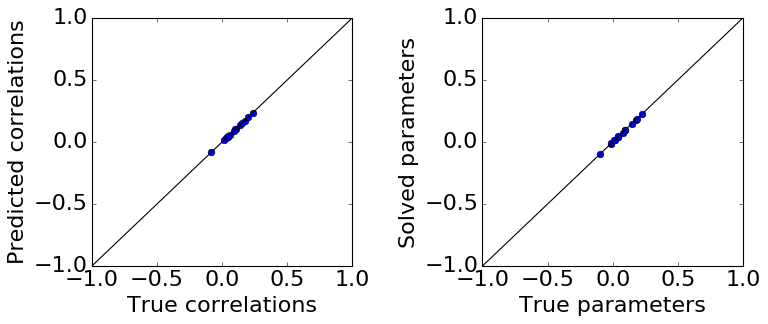

In [6]:
# Plot comparison of model results with the data.
fig,ax = plt.subplots(figsize=(10.5,4),ncols=2)
ax[0].plot(sisjTrue,ising_eqn_5_sym.calc_observables(estMultipliers),'o')
ax[0].plot([-1,1],[-1,1],'k-')
ax[0].set(xlabel='True correlations',ylabel='Predicted correlations')

ax[1].plot(hJ,soln['x'],'o')
ax[1].plot([-1,1],[-1,1],'k-')
ax[1].set(xlabel='True parameters',ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)

# Minimum probability flow (MPF)
MPF involves minimizing a much simpler objective function. One component that is necessary is the connectivity matrix defining which states are connected to each other such that probability can flow between them. This is defined in the `adj()` function for the Ising model.<br><br>
MPF is easily generalizable to arbitrary constraints by modifying `calc_observables()`.

In [7]:
# Declare and call solver.
# adj() was imported from coniii.utils at the beginning. It is a function for finding all the neighbors of a given state and is necessary for the MPF algorithm (called g_ij in Sohl-Dickstein 2011).
solver = MPF(n,calc_observables=calc_observables,adj=adj)
estMultipliers,soln = solver.solve(sample)

print "Error on multipliers: %E"%error_on_multipliers(estMultipliers)
print "Error on sample corr: %E"%error_on_correlations(
                        ising_eqn_5_sym.calc_observables(estMultipliers))

Error on multipliers: 8.282735E-01
Error on sample corr: 2.939210E-02


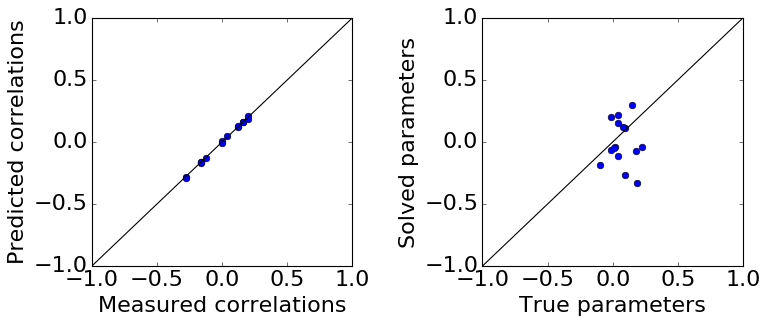

In [8]:
# Plot comparison of model results with the data.
fig,ax = plt.subplots(figsize=(10.5,4),ncols=2)
ax[0].plot(sisj,ising_eqn_5_sym.calc_observables(estMultipliers),'o')
ax[0].plot([-1,1],[-1,1],'k-')
ax[0].set(xlabel='Measured correlations',ylabel='Predicted correlations')

ax[1].plot(hJ,estMultipliers,'o')
ax[1].plot([-1,1],[-1,1],'k-')
ax[1].set(xlabel='True parameters',ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)

# Pseudolikelihood
Pseudollikelihood requires calculating the conditional probability for a single spin given the rest of the system  
>$p_{\rm r}=\left.p(\sigma_{\rm r}\right|\sigma\backslash\sigma_{\rm r})$.  

Pseudolikelihood is written specifically for the Ising system.<br><br>

It requires that the user define a function `get_multipliers_r()` that retrieves the parameters from the parameters vector relevant for calculating $p_{\rm r}$ and `calc_observables_r()` that calculates $p_{\rm r}$ from a sample of states. Template functions that work for the Ising model are defined in `utils.define_pseudo_ising_helpers()`.<br><br>

## Notes
- The coupling matrix is constrained to be symmetric in the code below $J_{\rm ij}=J_{\rm ji}$.

In [9]:
get_multipliers_r,calc_observables_r = define_pseudo_ising_helpers(n)

solver = Pseudo(n,calc_observables=calc_observables,
                calc_observables_r=calc_observables_r,
                get_multipliers_r=get_multipliers_r)
estMultipliers = solver.solve(sample,zeros(15))

print "Error on multipliers: %E"%error_on_multipliers(estMultipliers)
print "Error on sample corr: %E"%error_on_correlations(
                        ising_eqn_5_sym.calc_observables(estMultipliers))

Error on multipliers: 8.240198E-01
Error on sample corr: 3.591112E-03


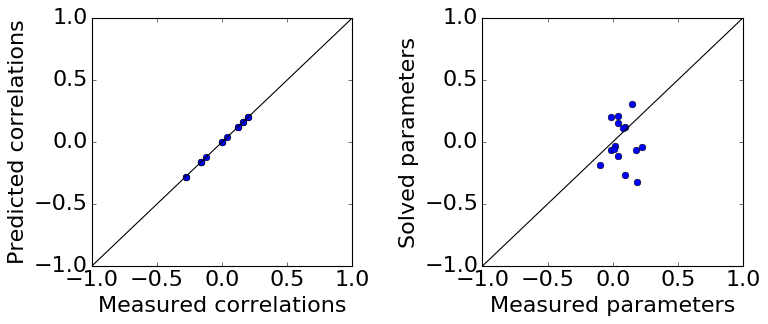

In [10]:
# Plot comparison of model results with the data.
fig,ax = plt.subplots(figsize=(10.5,4),ncols=2)
ax[0].plot(sisj,ising_eqn_5_sym.calc_observables(estMultipliers),'o')
ax[0].plot([-1,1],[-1,1],'k-')
ax[0].set(xlabel='Measured correlations',ylabel='Predicted correlations')

ax[1].plot(hJ,estMultipliers,'o')
ax[1].plot([-1,1],[-1,1],'k-')
ax[1].set(xlabel='Measured parameters',ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)

# Adaptive cluster expansion
Cluster expansion is written specifically for the Ising model.<br><br>
The user must specify a threshold that determines when the algorithm stops. A lower threshold will return a more accurate answer, but will also take longer to run.

In [8]:
solver = ClusterExpansion(n,calc_observables=calc_observables)
# Solver instance that does not use multiprocess module.
# solver = ClusterExpansion(n,calc_observables=calc_observables,n_jobs=0)

threshold = 0.001
estMultipliers = solver.solve(sample,threshold)

print "Error on multipliers: %E"%error_on_multipliers(estMultipliers)
print "Error on sample corr: %E"%error_on_correlations(
                        ising_eqn_5_sym.calc_observables(estMultipliers))

adaptiveClusterExpansion: Clusters of size 2
adaptiveClusterExpansion: Clusters of size 3
adaptiveClusterExpansion: Clusters of size 4
Error on multipliers: 7.982106E-01
Error on sample corr: 6.567170E-02


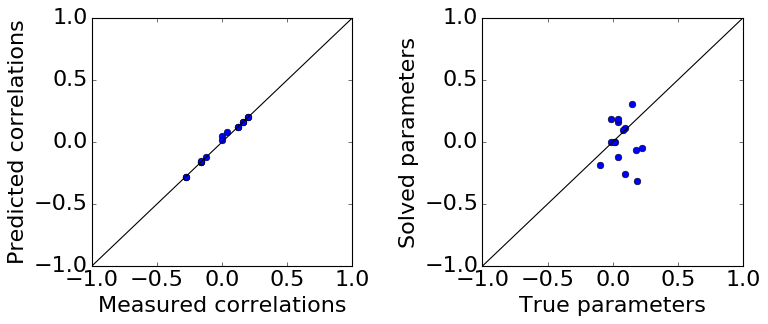

In [9]:
# Plot comparison of model results with the data.
fig,ax = plt.subplots(figsize=(10.5,4),ncols=2)
ax[0].plot(sisj,ising_eqn_5_sym.calc_observables(estMultipliers),'o')
ax[0].plot([-1,1],[-1,1],'k-')
ax[0].set(xlabel='Measured correlations',ylabel='Predicted correlations')

ax[1].plot(hJ,estMultipliers,'o')
ax[1].plot([-1,1],[-1,1],'k-')
ax[1].set(xlabel='True parameters',ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)

# Monte Carlo histogram (MCH)
MCH is easily generalizable to any maxent problem.<br><br>
MCH loops a sampling step for approximating the distribution with the current set of multipliers and then a run of the MCH approximation step on that sample. This method is the slow because of the time required for sampling from  $p(\sigma)$ and requires fine tuning to adjust the learning rule. <br><br>
The user must define how to perform the MCH approximation step for the problem at hand. The Ising model is already implemented in mchApproximation. The user must specify parameters for the sampling routine and the learning rule.
These can be modified during the run by passing in a function for the keyword `custom_convergence_f()`.<br><br>
The size of the sample will determine how accurately the algorithm can converge to the answer. Roughly speaking, you can expect your sampling error for each estimated correlation to scale as $1/\sqrt{K}$ where $K$ is your sample size.

In [3]:
# Sampling parameters must be set here (in case you want to immediately sample using 
# the given set of parameters)
solver = MCH(n,calc_observables=calc_observables,
             sample_size=100,
             sample_method='metropolis',
             mch_approximation=mchApproximation)
# Solver instance that does not use multiprocess module.
# solver = MCH(n,calc_observables=calc_observables,
#              sample_size=100,
#              sample_method='metropolis',
#              mch_approximation=mchApproximation,
#              n_jobs=0)

# Define function for changing learning parameters as we converge.
def learn_settings(i):
    """
    Take in the iteration counter and set the maximum change allowed in any given 
    parameter (maxdlamda) and the multiplicative factor eta, where 
    d(parameter) = (error in observable) * eta.
    
    Additional option is to also return the sample size for that step by returning a 
    tuple. Larger sample sizes are necessary for higher accuracy.
    """
    return {'maxdlamda':exp(-i/5.),'eta':exp(-i/5.)}

# Run solver.
estMultipliers = solver.solve(constraints=sisj,maxiter=40,custom_convergence_f=learn_settings)

print "Error on multipliers: %E"%error_on_multipliers(estMultipliers)
print "Error on sample corr: %E"%error_on_correlations(
                        ising_eqn_5_sym.calc_observables(estMultipliers))

/Users/eddie/Dropbox/Research/py_lib/coniii/solvers.py:656: UserWarning: Number of burn in MCMC iterations between samples may be too small for convergence to stationary distribution.
  "convergence to stationary distribution.")
/Users/eddie/Dropbox/Research/py_lib/coniii/solvers.py:659: UserWarning: Number of MCMC iterations between samples may be too small for convergence to stationary distribution.
  "stationary distribution.")


Error on multipliers: 8.226204E-01
Error on sample corr: 8.226007E-02


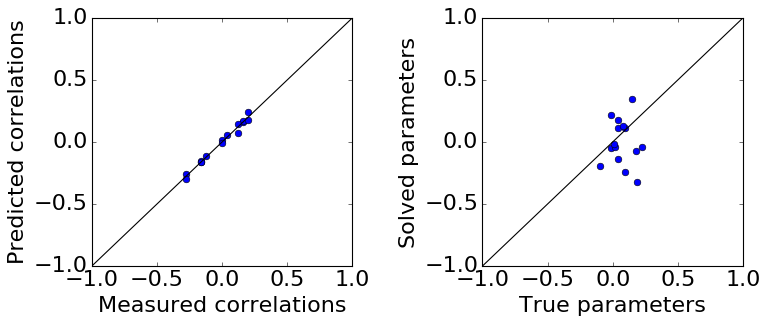

In [4]:
# Plot comparison of model results with the data.
fig,ax = plt.subplots(figsize=(10.5,4),ncols=2)
ax[0].plot(sisj,ising_eqn_5_sym.calc_observables(estMultipliers),'o')
ax[0].plot([-1,1],[-1,1],'k-')
ax[0].set(xlabel='Measured correlations',ylabel='Predicted correlations')

ax[1].plot(hJ,estMultipliers,'o')
ax[1].plot([-1,1],[-1,1],'k-')
ax[1].set(xlabel='True parameters',ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)

# Regularized mean field

In [5]:
solver = RegularizedMeanField(n,calc_observables=calc_observables)
# Solver instance that does not use multiprocess module.
# solver = RegularizedMeanField(n,calc_observables=calc_observables,n_jobs=0)
estMultipliers = solver.solve(sample,numSamples=100)

print "Error on multipliers: %E"%error_on_multipliers(estMultipliers)
print "Error on sample corr: %E"%error_on_correlations(
                        ising_eqn_5_sym.calc_observables(estMultipliers))

coocSampleCovariance : WARNING : using ad-hoc 'Laplace' correction
Error on multipliers: 1.256582E+00
Error on sample corr: 6.169199E-01


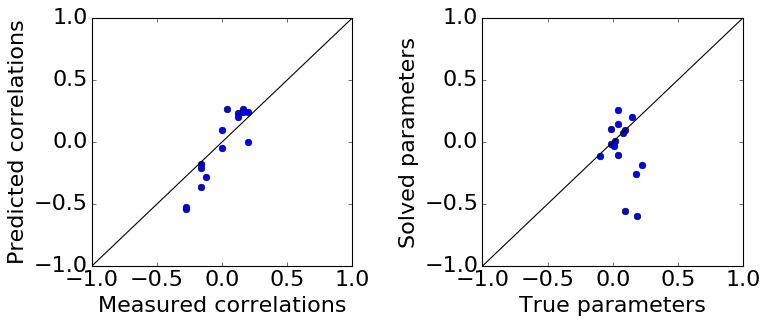

In [4]:
# Plot comparison of model results with the data.
fig,ax = plt.subplots(figsize=(10.5,4),ncols=2)
ax[0].plot(sisj,ising_eqn_5_sym.calc_observables(estMultipliers),'o')
ax[0].plot([-1,1],[-1,1],'k-')
ax[0].set(xlabel='Measured correlations',ylabel='Predicted correlations')

ax[1].plot(hJ,estMultipliers,'o')
ax[1].plot([-1,1],[-1,1],'k-')
ax[1].set(xlabel='True parameters',ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)